In [1]:
import torch 
from torch import nn
import numpy as np
from score_sde import VPSDE, subVPSDE, VESDE
from score_net import TimeConditionalScoreNet
from score_loss import continuous_denoised_loss, continuous_score_matching_loss,continuous_sliced_score_matching_loss

import tqdm
import sbibm 
from sbibm.metrics import c2st

import matplotlib.pyplot as plt


In [2]:
task = sbibm.get_task("two_moons")
prior = task.get_prior_dist()
simulator = task.get_simulator()

thetas = prior.sample((10000,))
xs = simulator(thetas)

In [3]:
from sspe import ScoreEstimator

In [4]:
inf = ScoreEstimator(prior, show_progress_bars=True)

In [5]:
scorenet = inf.append_simulations(thetas, xs).train(stop_after_epochs=100, training_batch_size=1000, max_num_epochs=200, show_train_summary=True)


        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 201
        Best validation performance: -0.0004
        -------------------------
        


In [6]:
posterior = inf.build_posterior(scorenet)
posterior.set_default_x(task.get_observation(1))

ScoreBasedPosterior(
               method_family=snle,
               net=<a TimeConditionalScoreNet, see `.net` for details>,
               prior=Independent(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1),
               x_shape=torch.Size([1, 2]))
               

In [9]:
samples = posterior.sample((5000,2), sample_with="sde")

KeyError: 'sampler_name'

In [13]:
import torchsde

batch_size, state_size, brownian_size = 32, 3, 2
t_size = 20

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(state_size, 
                                  state_size)
        self.sigma = torch.nn.Linear(state_size, 
                                     state_size * brownian_size)

    # Drift
    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(batch_size, 
                                  state_size, 
                                  brownian_size)

sde = SDE()
y0 = torch.full((batch_size, state_size), 0.1)
ts = torch.linspace(0, 1, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, y0, ts)

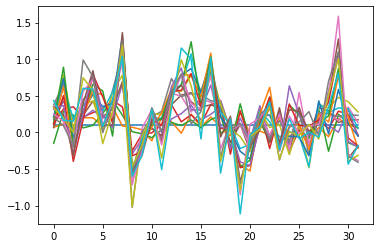

In [19]:
for y in ys:
    plt.plot(y[:,0].detach())

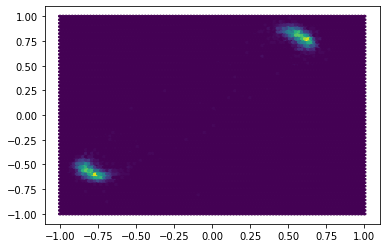

In [8]:
plt.hexbin(samples[:,0], samples[:,1],extent=[-1,1,-1,1])

In [10]:
log_probs = posterior.log_prob(samples)

In [ ]:
log_probs

In [6]:
from score_sampling import get_pc_sampler, EulerMaruyamaPredictor,NoneCorrector, get_adaptive_pc_sampler, AdaptivePredictor, get_ode_sampler

In [7]:
sampling_fn = get_ode_sampler(inf.sde,lambda x:x)

In [8]:
samples = sampling_fn(scorenet, (1000,2), task.get_observation(1).repeat(1000,1),atol=1e-3, rtol=1e-3)

In [9]:
from score_log_prob import get_likelihood_fn

In [13]:
from score_sampling import get_sampling_fn

get_sampling_fn("ode_sampler", inf.sde)

<function score_sampling.get_ode_sampler.<locals>.ode_sampler(model, shape, context, z=None, rtol=0.001, atol=0.001, method='RK45')>

In [11]:
log_prob = get_likelihood_fn(inf.sde, lambda x:x)

In [12]:
probs = log_prob(scorenet, samples[:1000], context=task.get_observation(1).repeat(1000,1)).exp()

(-1.0, 1.0)

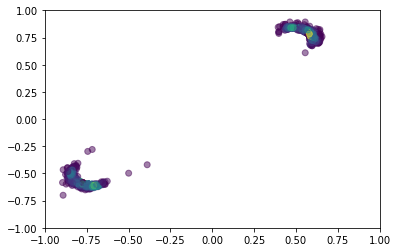

In [32]:
plt.scatter(samples[:1000,0], samples[:1000,1], c=probs.clamp_max(probs.quantile(0.99)), alpha=0.5)
plt.ylim(-1,1)
plt.xlim(-1,1)

In [ ]:
plt.hexbin(samples[:,0], samples[:,1],extent=[-1,1,-1,1])

In [20]:
sde = VESDE()
#scorenet = TimeConditionalScoreNet(2, sde.marginal_prob, context_dim=2, num_layers=5, hidden_dim=50, p_dropout=0.0)

In [18]:
net = scorenet

In [29]:
data = [(theta, x) for theta, x in zip(thetas,xs)]
data = torch.utils.data.DataLoader(data, shuffle=True, batch_size=1000)
optimizer = torch.optim.Adam(scorenet.parameters(), lr=1e-3)
epochs = tqdm.tqdm(range(100))
scorenet.train()
for ep in epochs:
    for theta,x in data:
        optimizer.zero_grad()
        loss = continuous_denoised_loss(scorenet, theta, context=x)
        loss.backward()
        optimizer.step()
        epochs.set_description(f"Loss: {loss}")

Loss: 0.38204729557037354: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


In [59]:
from score_sampling import get_pc_sampler, EulerMaruyamaPredictor, NoneCorrector, LangevinCorrector, AdaptivePredictor
sampling_function = get_pc_sampler(sde, (1,2), AdaptivePredictor, NoneCorrector,context=task.get_observation(1).repeat(1000,1), eps=1e-7, snr=0.1, inverse_scaler=lambda x:x)

In [60]:
samples = sampling_function(scorenet)[0]

TypeError: 'bool' object is not subscriptable

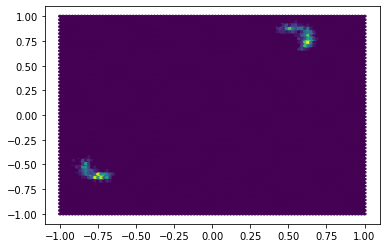

In [58]:
plt.hexbin(samples[:,0], samples[:,1], extent=[-1,1,-1,1])

In [21]:
x_obs = task.get_observation(1)
scorenet.eval()
score_fn = lambda x, t: scorenet(x, t,context=x_obs.repeat(x.shape[0],1)) 
rev_sde = sde.reverse(score_fn)

In [62]:
torch.vmap

AttributeError: module 'torch' has no attribute 'vmap'

In [22]:
def euler_maruyana_sample(shape, eps=1e-7):
    with torch.no_grad():
        x = sde.prior_sampling(shape)
        timesteps = torch.linspace(sde.T, eps, sde.N)
        for i in range(sde.N):
            t = timesteps[i]
            dt = -1/rev_sde.N
            z = torch.randn_like(x)
            drift, diffusion = rev_sde.sde(x, t.repeat(shape[0],1))
            x_mean = x + drift*dt 
            x = x_mean + diffusion*np.sqrt(-dt)*z
    return x

In [70]:
def runge_kutta_order1(shape, eps=1e-7):
    with torch.no_grad():
        x = sde.prior_sampling(shape)
        timesteps = torch.linspace(sde.T, eps, sde.N)
        for i in range(sde.N):
            t = timesteps[i]
            dt = -1/sde.N
            z = torch.randn_like(x)*np.sqrt(-dt)
            drift, diffusion = rev_sde.sde(x, t.repeat(shape[0],1))
            x_help = x + drift*dt + diffusion*np.sqrt(-dt)
            _, diffusion_help = rev_sde.sde(x_help, t.repeat(shape[0],1))
            x = x + drift*dt + diffusion*z + 0.5*(diffusion_help - diffusion)*(z**2-dt)*(-dt)**(-0.5)
    return x

In [25]:
samples = euler_maruyana_sample((10000,2), eps=1e-7)

In [48]:
samples = runge_kutta_order1((10000,2), eps=1e-7)

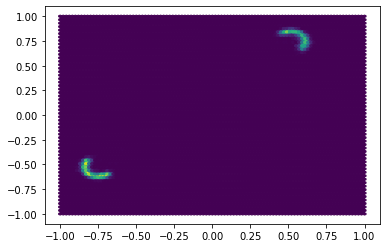

In [26]:
plt.hexbin(samples[:,0], samples[:,1], extent=[-1,1,-1,1])

In [50]:
ref_samples = task.get_reference_posterior_samples(1)
c2st(samples, ref_samples)

tensor([0.5190])

In [29]:
all_samples = []
for i in range(1,9):
    x_obs = task.get_observation(i)
    scorenet.eval()
    score_fn = lambda x, t: scorenet(x, t,context=x_obs.repeat(x.shape[0],1)) 
    rev_sde = sde.reverse(score_fn)
    samples = euler_maruyana_sample((10000,2))
    all_samples.append(samples)

In [30]:
c2sts = []
for i,samples in enumerate(all_samples):
    ref_samples = task.get_reference_posterior_samples(i+1)
    c2sts.append(c2st(samples, ref_samples))

In [31]:
torch.mean(torch.stack(c2sts))

tensor(0.5489)

## Mulit round

SNPE-A is applicable. It even is "easier" as for density estimation as **the normalizing constant becomes zero**
$$ p(\theta|x) = q_\phi(\theta|x)\frac{p(\theta)}{\hat{p(\theta)}} \frac{1}{Z(x)} \iff \nabla_\theta \log p(\theta|x) = \nabla_\theta \log q_\phi(\theta|x)+\nabla_\theta p(\theta) - \nabla_\theta \hat{p}(\theta) $$

Thus we can adjust the score matching objectivate as
$$ \mathbb{E}_{p_\sigma(\tilde{\theta}|\theta,x)p(x)}\left[||s_\phi^{r}(\tilde{\theta}, \sigma, x) + s^{r-1}(\tilde{\theta}, \sigma, x)  - \nabla_\theta p(\theta) - \nabla_{\theta} p_\sigma(\tilde{\theta}|\theta,x) ||_2^2 \right]$$

In [61]:
from copy import deepcopy
sde = VESDE()
scorenet = ContinousTimeDenseScoreNet(2, sde.marginal_prob, context_dim=2, nonlinearity=nn.ELU, normalization=nn.LayerNorm)

In [62]:
# First round
thetas = prior.sample((1000,))
xs = simulator(thetas)
data = [(theta, x) for theta, x in zip(thetas,xs)]
data = torch.utils.data.DataLoader(data, shuffle=True, batch_size=200)

In [68]:
optimizer = torch.optim.Adam(scorenet.parameters(), lr=1e-3)
epochs = tqdm.tqdm(range(200))
scorenet.train()
for ep in epochs:
    for theta,x in data:
        optimizer.zero_grad()
        loss = continuous_denoised_loss(scorenet, theta, context=x, eps=1e-7)
        loss.backward()
        optimizer.step()
        epochs.set_description(f"Loss: {loss}")

Loss: 0.34832537174224854: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


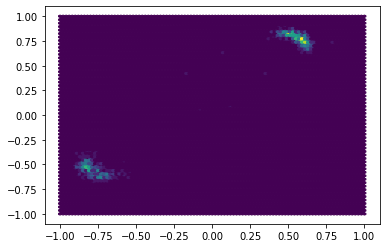

In [157]:
# Second round:
x_obs = task.get_observation(1)
scorenet.eval()
score_fn = lambda x, t: scorenet(x, t,context=x_obs.repeat(x.shape[0],1)) 
rev_sde = sde.reverse(score_fn)
samples = euler_maruyana_sample((1000,2))
xs = simulator(samples)
plt.hexbin(samples[:,0], samples[:,1], extent=[-1,1,-1,1])

In [158]:
scorenet2 = ContinousTimeDenseScoreNet(2, sde.marginal_prob, context_dim=2, nonlinearity=nn.ELU, normalization=nn.LayerNorm)
scorenet2.load_state_dict(scorenet.state_dict())

<All keys matched successfully>

In [159]:
data2 = [(theta, x) for theta, x in zip(samples,xs)]
data2 = torch.utils.data.DataLoader(data2, shuffle=True, batch_size=900)

In [160]:
optimizer = torch.optim.Adam(scorenet2.parameters(), lr=1e-3)
epochs = tqdm.tqdm(range(500))
scorenet2.train()
for ep in epochs:
    for theta,x in data:
        optimizer.zero_grad()
        loss = continuous_denoised_loss(scorenet2, theta, context=x, eps=1e-7)
        loss.backward()
        optimizer.step()
        epochs.set_description(f"Loss: {loss}")
    for theta,x in data2:
        optimizer.zero_grad()
        #loss = continuous_denoised_loss(scorenet2, theta, context=x, eps=1e-7)
        context = x 
        x=theta
        eps = 1e-7 
        random_t = torch.rand((x.shape[0], 1)) * (1.0 - eps) + eps
        z = torch.randn_like(x)
        std = scorenet2.marginal_prob(torch.zeros_like(x), random_t)[1]
        perturbed_x = x + z * std
        score = scorenet2(perturbed_x, random_t, context=context)
        # Substract proposal score, prior score is zero as uniform distribution...
        loss = torch.mean(torch.sum(((score + scorenet(x, random_t,context=context)) * std + z) ** 2, dim=-1))
        loss.backward()
        optimizer.step()
        epochs.set_description(f"Loss: {loss}")

Loss: 0.8198363780975342: 100%|██████████| 500/500 [01:03<00:00,  7.85it/s]


In [161]:
x_obs = task.get_observation(1)
scorenet.eval()
scorenet2.eval()
score_fn = lambda x, t: scorenet2(x, t,context=x_obs.repeat(x.shape[0],1))
rev_sde = sde.reverse(score_fn)

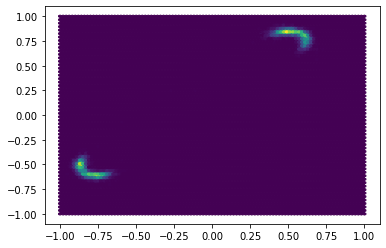

In [162]:
samples = euler_maruyana_sample((10000,2))
plt.hexbin(samples[:,0], samples[:,1],extent=[-1,1,-1,1])